# Notebook 2: HMM Training, Analysis, and Visualization

**Objective:** Load the logged inference trajectories, train an HMM surrogate, analyze its learned states, and visualize its behavior on test reviews.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# Add src directory to Python path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.config import (
    LOG_FILE_PATH, HMM_MODEL_PATH, TARGET_SENTIMENT,
    NUM_TEST_SAMPLES, MAX_TOKENS, MODEL_NAME, DEVICE
)
from src.hmm_surrogate import HMMSurrogate
from src.data_utils import load_imdb_data, preprocess_data_for_inference_logging
from src.black_box_model import BlackBoxSentimentClassifier, log_inference_trajectories
from src.visualization_utils import plot_state_timeline, plot_hmm_transition_matrix, plot_avg_probabilities_per_state

%matplotlib inline

/home/gamerio/miniconda3/envs/playground/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Logged Inference Trajectories

In [2]:
try:
    loaded_data = np.load(LOG_FILE_PATH)
    train_trajectories = [loaded_data[f'arr_{i}'] for i in range(len(loaded_data.files))]
    print(f"Loaded {len(train_trajectories)} trajectories from {LOG_FILE_PATH}.")
    if train_trajectories:
        print(f"Example trajectory 0 shape: {train_trajectories[0].shape}")
except FileNotFoundError:
    print(f"Error: Log file {LOG_FILE_PATH} not found. Please run Notebook 1 first.")
    train_trajectories = []

Loaded 25000 trajectories from data/imbd_inference_logs25k.npz.
Example trajectory 0 shape: (512, 2)


## 2. Train HMM Surrogate

In [3]:
hmm_surrogate_model = None
if train_trajectories:
    hmm_surrogate_model = HMMSurrogate() # Uses N_HMM_STATES from config
    hmm_surrogate_model.train(train_trajectories)
    
    # Save the trained HMM model
    if not os.path.exists('models'):
        os.makedirs('models')
    hmm_surrogate_model.save_model(HMM_MODEL_PATH)
else:
    print("Skipping HMM training as no trajectories were loaded.")

Training HMM with 4 states on 25000 sequences.
Total observations: 6882586, Observation dim: 2


         1 10879139.17435300             +nan
         2 52923032.85934294 +42043893.68498994
         3 58497580.30788117 +5574547.44853823
         4 61309568.50942670 +2811988.20154553
         5 63219784.26163490 +1910215.75220820
         6 64533387.41697466 +1313603.15533976
         7 65326655.57627290 +793268.15929824
         8 66050902.55969535 +724246.98342245
         9 66493836.89777400 +442934.33807866
        10 66856676.80999774 +362839.91222373
        11 67110527.34883647 +253850.53883873
        12 67304177.73335744 +193650.38452098
        13 67450401.10561623 +146223.37225878
        14 67557811.69261734 +107410.58700112
        15 67637797.81946419  +79986.12684685
        16 67696647.96656096  +58850.14709677
        17 67740634.62310968  +43986.65654872
        18 67773269.42631452  +32634.80320483
        19 67796376.25922398  +23106.83290946
        20 67813098.78367816  +16722.52445418
        21 67825433.69627285  +12334.91259469
        22 67834529.22572729

HMM training complete.

--- HMM Parameters ---
Initial state probabilities (startprob_):
 [0.00000000e+000 1.00000000e+000 0.00000000e+000 3.14803439e-270]

Transition matrix (transmat_):
 [[9.96086409e-01 0.00000000e+00 7.74835749e-07 3.91281625e-03]
 [8.72662207e-04 0.00000000e+00 7.26897682e-03 9.91858361e-01]
 [4.06579211e-05 0.00000000e+00 9.94756698e-01 5.20264447e-03]
 [7.00615560e-03 3.48039618e-40 8.12176589e-03 9.84872079e-01]]

Emission probabilities (means_ for GaussianHMM):
 [[0.98723811 0.01276189]
 [0.35785007 0.64214998]
 [0.01603738 0.98396262]
 [0.49466587 0.50533413]]

Emission covariances (covars_ for GaussianHMM):
 [[[ 8.08973013e-05 -8.08878665e-05]
  [-8.08878665e-05  8.08973016e-05]]

 [[ 4.00000000e-07  3.99999948e-07]
  [ 3.99999948e-07  3.99999912e-07]]

 [[ 1.33701114e-04 -1.33691844e-04]
  [-1.33691844e-04  1.33701114e-04]]

 [[ 1.13571074e-01 -1.13571066e-01]
  [-1.13571066e-01  1.13571074e-01]]]
HMM model saved to models/sentiment_hmm25k_4states.pkl


In [ ]:
#hmm_surrogate_model = HMMSurrogate.load_model(HMM_MODEL_PATH)

## 3. Analyze HMM Parameters and States

If you didn't just train, you can load a pre-trained HMM model.


--- HMM State Analysis ---
State 0: Occurrences = 2120770, Avg. P(Class 1) = 0.013
State 1: Occurrences = 25000, Avg. P(Class 1) = 0.642
State 2: Occurrences = 2158221, Avg. P(Class 1) = 0.984
State 3: Occurrences = 2578595, Avg. P(Class 1) = 0.505

Suggested State Interpretations (based on P(Class {target_class_idx})):
  HMM State 0: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.013)
  HMM State 3: ~Neutral/Uncertain (Avg. P(Class 1) = 0.505)
  HMM State 1: ~Neutral/Uncertain (Avg. P(Class 1) = 0.642)
  HMM State 2: ~Leaning Positive/High Confidence (Avg. P(Class 1) = 0.984)


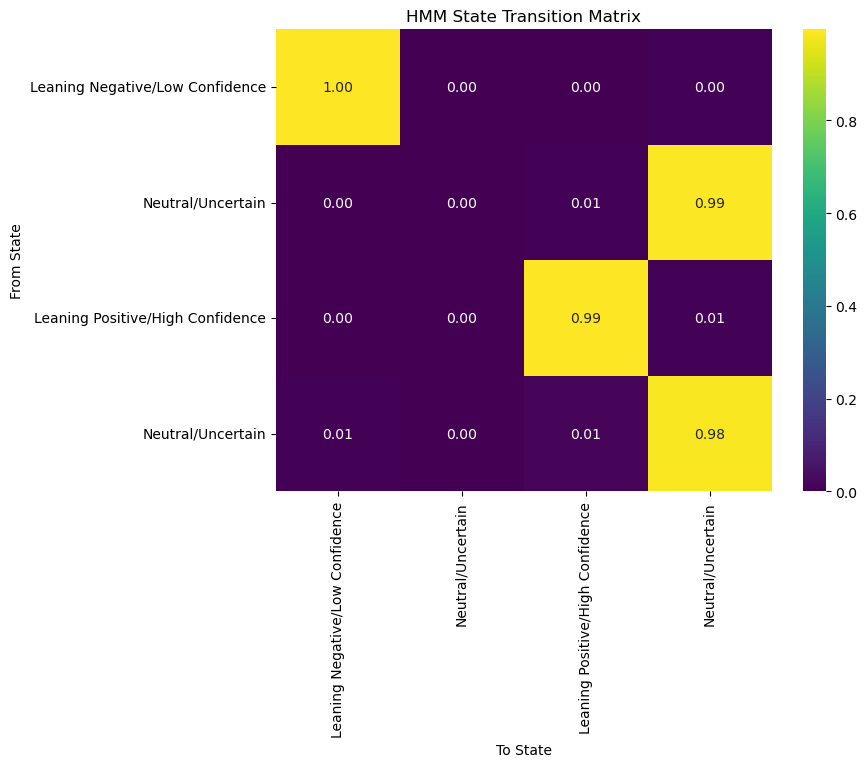

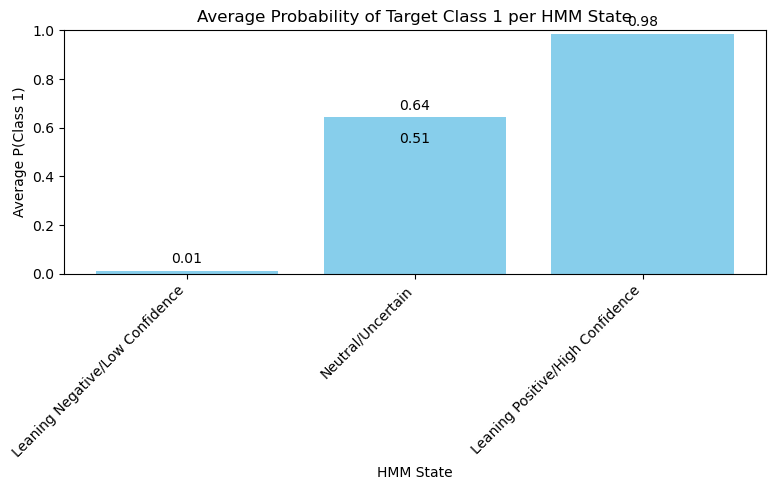

In [4]:
if hmm_surrogate_model is None or not hmm_surrogate_model.is_trained:
    print(f"Attempting to load pre-trained HMM from {HMM_MODEL_PATH}")
    try:
        hmm_surrogate_model = HMMSurrogate()
        hmm_surrogate_model.load_model(HMM_MODEL_PATH)
    except FileNotFoundError:
        print(f"Error: Pre-trained HMM model not found at {HMM_MODEL_PATH}. Please train one first.")
        hmm_surrogate_model = None # Ensure it's None if loading fails

state_analysis_results = None
if hmm_surrogate_model and hmm_surrogate_model.is_trained and train_trajectories:
    # For state analysis, we need decoded states for the training trajectories
    decoded_train_states = [hmm_surrogate_model.decode_sequence(traj) for traj in train_trajectories if traj.shape[0] > 0]
    
    # Filter out empty sequences from train_trajectories if their decoded_train_states are empty
    valid_train_trajectories = [traj for traj, states in zip(train_trajectories, decoded_train_states) if states.size > 0]
    valid_decoded_train_states = [states for states in decoded_train_states if states.size > 0]

    state_analysis_results = hmm_surrogate_model.analyze_states(
        valid_train_trajectories, 
        valid_decoded_train_states, 
        target_class_idx=TARGET_SENTIMENT
    )
    
    # Visualize HMM parameters
    plot_hmm_transition_matrix(hmm_surrogate_model.model, state_names=state_analysis_results.get('state_names'))
    plot_avg_probabilities_per_state(state_analysis_results, target_class_idx=TARGET_SENTIMENT)

## 4. Visualize HMM Behavior on Test Reviews

Load a few test reviews, get their black-box probability trajectories, decode HMM states, and plot.


--- Visualizing HMM on Test Reviews ---
Model loaded successfully on cuda
loaded black box model: lvwerra/distilbert-imdb
Labels: {0: 'NEGATIVE', 1: 'POSITIVE'}


Processing data: 100%|██████████| 20/20 [00:30<00:00,  1.54s/it]



Visualizing Test Sample 1:
Text: I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Bab...

Sentence tokens with HMM colors:
[CLS] i love sci - fi and am willing to put up with a lot . sci - fi movies / tv are usually under ##fu ##nded , under - appreciated and misunderstood . i tried to like this , i really did , but it is to good tv sci - fi as babylon 5 is to star trek ( the original ) . silly pro ##st ##hetic ##s , cheap cardboard sets , stil ##ted dialogues , c ##g that doesn ' t match the background , and painfully one - dimensional characters cannot be overcome with a ' sci - fi ' setting . ( i ' m sure there are those of you out there who think babylon 5 is good sci - fi tv . it ' s not . it ' s cl ##iche ##d and un ##ins ##pi ##ring . ) while us viewers might like emotion and character development , sci - fi is a genre that does not

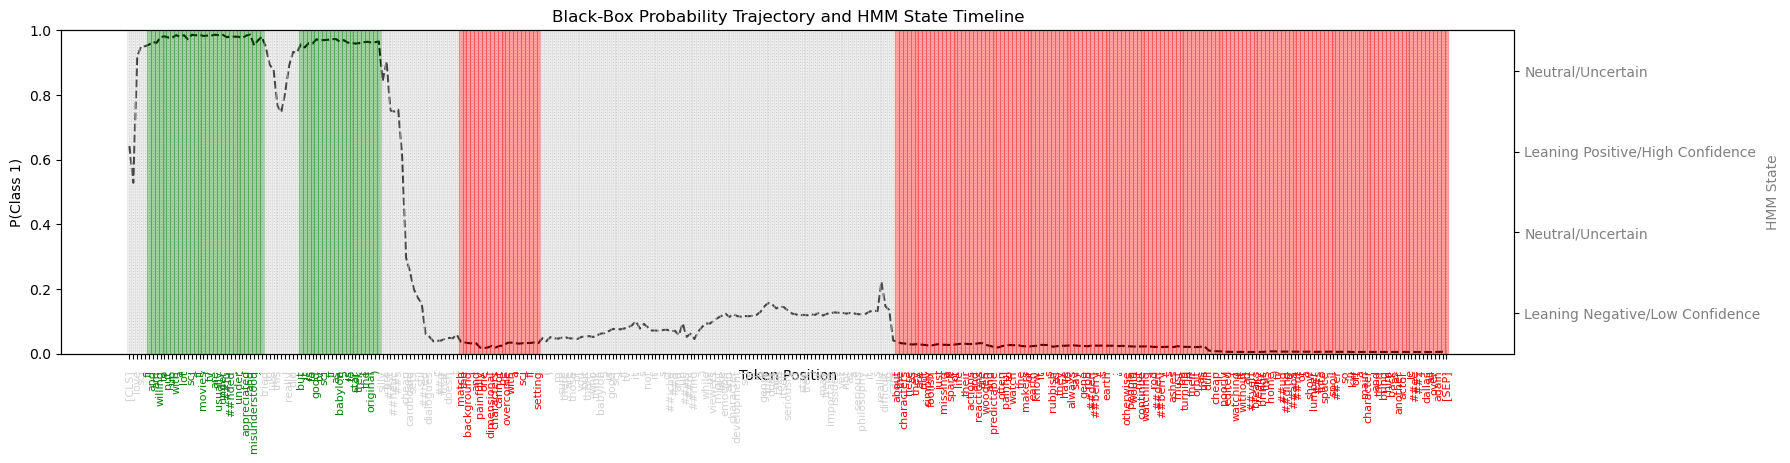


Visualizing Test Sample 2:
Text: Worth the entertainment value of a rental, especially if you like action movies. This one features the usual car chases, fights with the great Van Damme kick style, shooting battles with the 40 shell ...

Sentence tokens with HMM colors:
[CLS] worth the entertainment value of a rental , especially if you like action movies . this one features the usual car chases , fights with the great van dam ##me kick style , shooting battles with the 40 shell load shotgun , and even terrorist style bombs . all of this is entertaining and competent ##ly handled but there is nothing that really blows you away if you ' ve seen your share before . < br / > < br / > the plot is made interesting by the inclusion of a rabbit , which is clever but hardly profound . many of the characters are heavily stereo ##type ##d - - the angry veterans , the terrified illegal aliens , the crooked cops , the indifferent fed ##s , the bitch ##y tough lady station head , the crooked polit

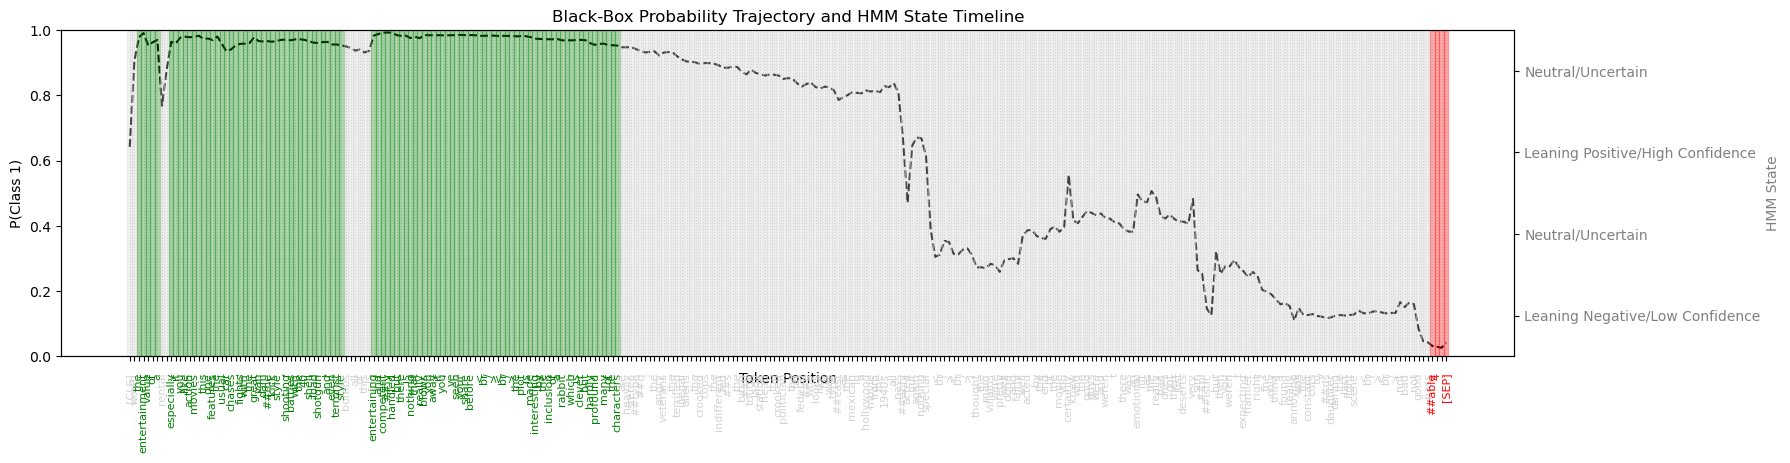


Visualizing Test Sample 3:
Text: its a totally average film with a few semi-alright action sequences that make the plot seem a little better and remind the viewer of the classic van dam films. parts of the plot don't make sense and s...

Sentence tokens with HMM colors:
[CLS] its a totally average film with a few semi - alright action sequences that make the plot seem a little better and remind the viewer of the classic van dam films . parts of the plot don ' t make sense and seem to be added in to use up time . the end plot is that of a very basic type that doesn ' t leave the viewer guessing and any twists are obvious from the beginning . the end scene with the fl ##ask backs don ' t make sense as they are added in and seem to have little relevance to the history of van dam ' s character . not really worth watching again , bit disappointed in the end production , even though it is apparent it was shot on a low budget certain shots and sections in the film are of poor directed qualit

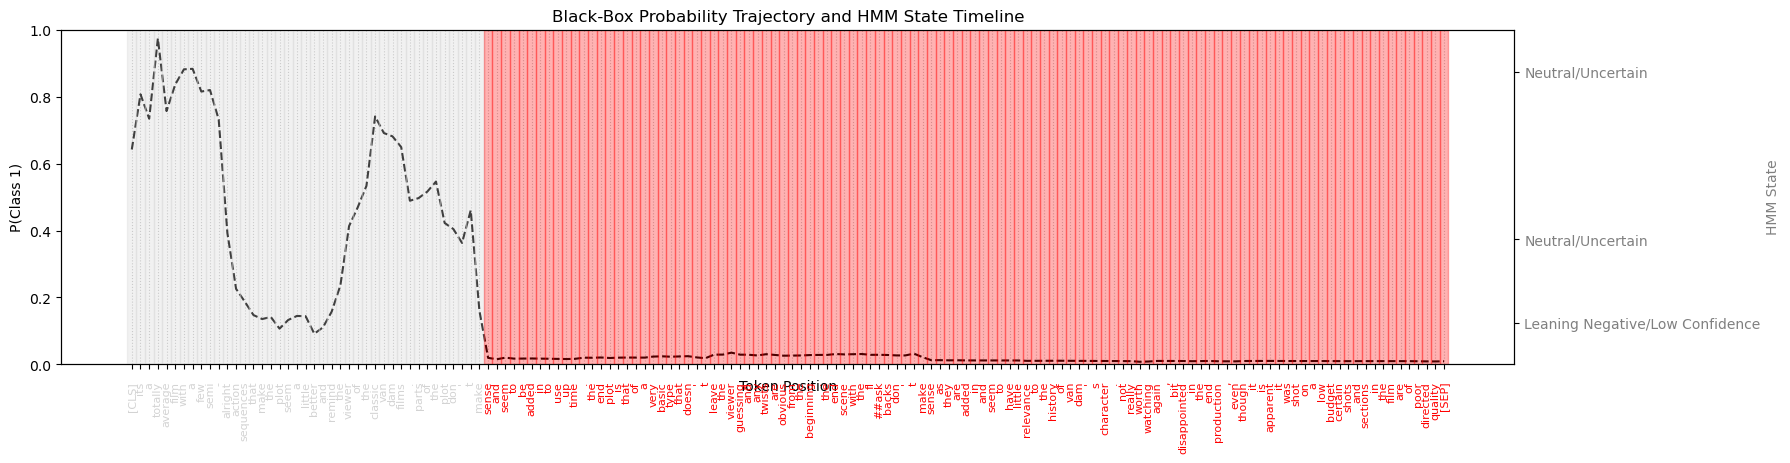


Visualizing Test Sample 4:
Text: STAR RATING: ***** Saturday Night **** Friday Night *** Friday Morning ** Sunday Night * Monday Morning <br /><br />Former New Orleans homicide cop Jack Robideaux (Jean Claude Van Damme) is re-assigne...

Sentence tokens with HMM colors:
[CLS] star rating : * * * * * saturday night * * * * friday night * * * friday morning * * sunday night * monday morning < br / > < br / > former new orleans homicide cop jack rob ##ide ##aux ( jean claude van dam ##me ) is re - assigned to columbus , a small but violent town in mexico to help the police there with their efforts to stop a major heroin smuggling operation into their town . the cu ##lp ##rit ##s turn out to be ex - military , lead by former commander benjamin meyer ##s ( stephen lord , otherwise known as jase from east end ##ers ) who is using a special method he learned in afghanistan to fight off his opponents . but jack has a more personal reason for taking him down , that draws the two men into an ex

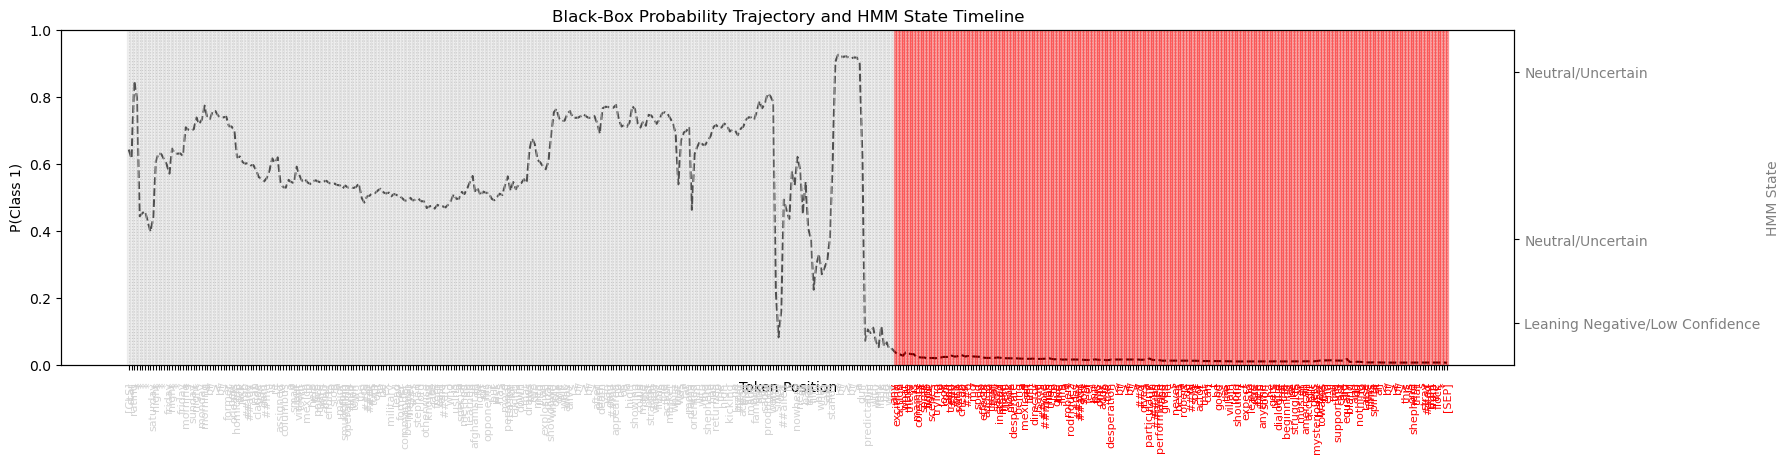


Visualizing Test Sample 5:
Text: First off let me say, If you haven't enjoyed a Van Damme movie since bloodsport, you probably will not like this movie. Most of these movies may not have the best plots or best actors but I enjoy thes...

Sentence tokens with HMM colors:
[CLS] first off let me say , if you haven ' t enjoyed a van dam ##me movie since blood ##sport , you probably will not like this movie . most of these movies may not have the best plots or best actors but i enjoy these kinds of movies for what they are . this movie is much better than any of the movies the other action guys ( sega ##l and do ##lp ##h ) have thought about putting out the past few years . van dam ##me is good in the movie , the movie is only worth watching to van dam ##me fans . it is not as good as wake of death ( which i highly recommend to anyone of likes van dam ##me ) or in hell but , in my opinion it ' s worth watching . it has the same type of feel to it as nowhere to run . good fun stuff ! [SEP] 

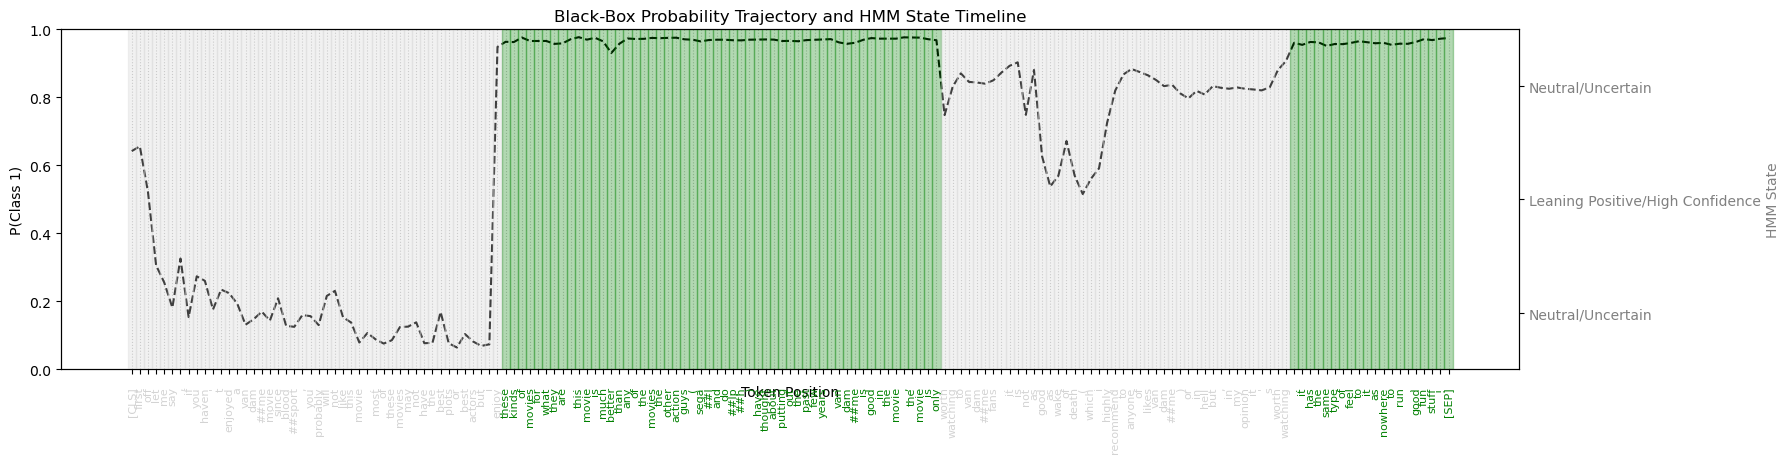


Visualizing Test Sample 6:
Text: I had high hopes for this one until they changed the name to 'The Shepherd : Border Patrol, the lamest movie name ever, what was wrong with just 'The Shepherd'. This is a by the numbers action flick t...

Sentence tokens with HMM colors:
[CLS] i had high hopes for this one until they changed the name to ' the shepherd : border patrol , the lame ##st movie name ever , what was wrong with just ' the shepherd ' . this is a by the numbers action flick that tips its hat at many classic van dam ##me films . there is a nice bit of action in a bar which reminded me of hard target and universal soldier but directed with no intensity or flair which is a shame . there is one great line about ' being p * ss drunk and carrying a rabbit ' and some ok action scenes let down by the cheap ##ness of it all . a lot of the times the dialogue doesn ' t match the characters mouth and the stunt men fall down dead a split second before even being shot . the end fight is one o

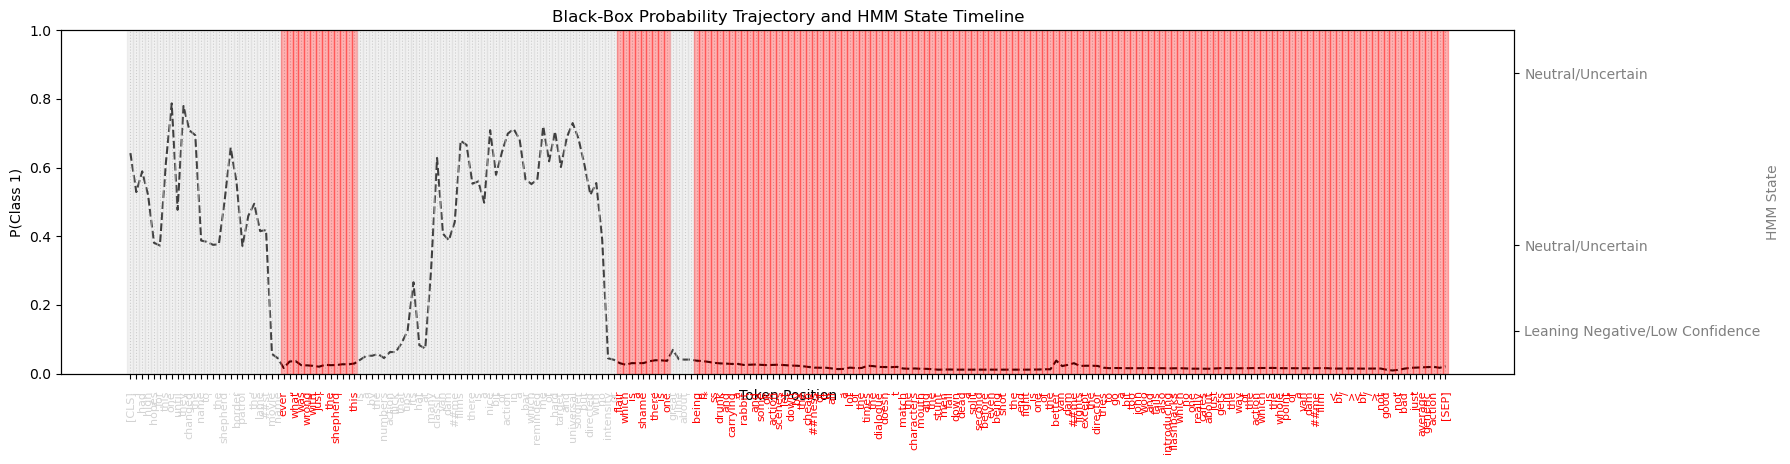


Visualizing Test Sample 7:
Text: Isaac Florentine has made some of the best western Martial Arts action movies ever produced. In particular US Seals 2, Cold Harvest, Special Forces and Undisputed 2 are all action classics. You can te...

Sentence tokens with HMM colors:
[CLS] isaac fl ##ore ##ntine has made some of the best western martial arts action movies ever produced . in particular us seals 2 , cold harvest , special forces and und ##is ##puted 2 are all action classics . you can tell isaac has a real passion for the genre and his films are always event ##ful , creative and sharp affairs , with some of the best fight sequences an action fan could hope for . in particular he has found a muse with scott ad ##kins , as talented an actor and action performer as you could hope for . this is borne out with special forces and und ##is ##puted 2 , but unfortunately the shepherd just doesn ' t live up to their abilities . < br / > < br / > there is no doubt that jc ##vd looks better here

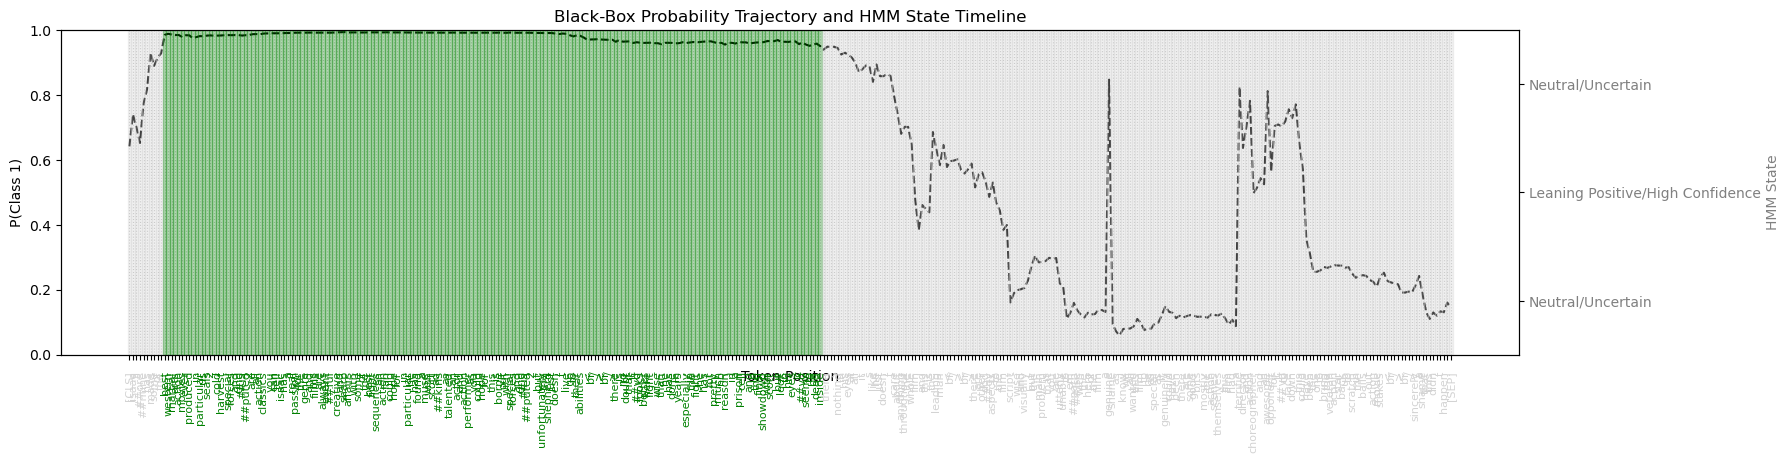


Visualizing Test Sample 8:
Text: It actually pains me to say it, but this movie was horrible on every level. The blame does not lie entirely with Van Damme as you can see he tried his best, but let's face it, he's almost fifty, how m...

Sentence tokens with HMM colors:
[CLS] it actually pains me to say it , but this movie was horrible on every level . the blame does not lie entirely with van dam ##me as you can see he tried his best , but let ' s face it , he ' s almost fifty , how much more can you ask of him ? i find it so hard to believe that the same people who put together und ##is ##puted 2 ; arguably the best ( western ) martial arts movie in years , created this . everything from the plot , to the dial ##og , to the editing , to the overall acting was just horribly put together and in many cases outright boring and non ##sen ##sic ##al . scott ad ##kins who ' s fight scenes seemed more like a demo reel , was also terribly under ##used and not even the main villain which is su

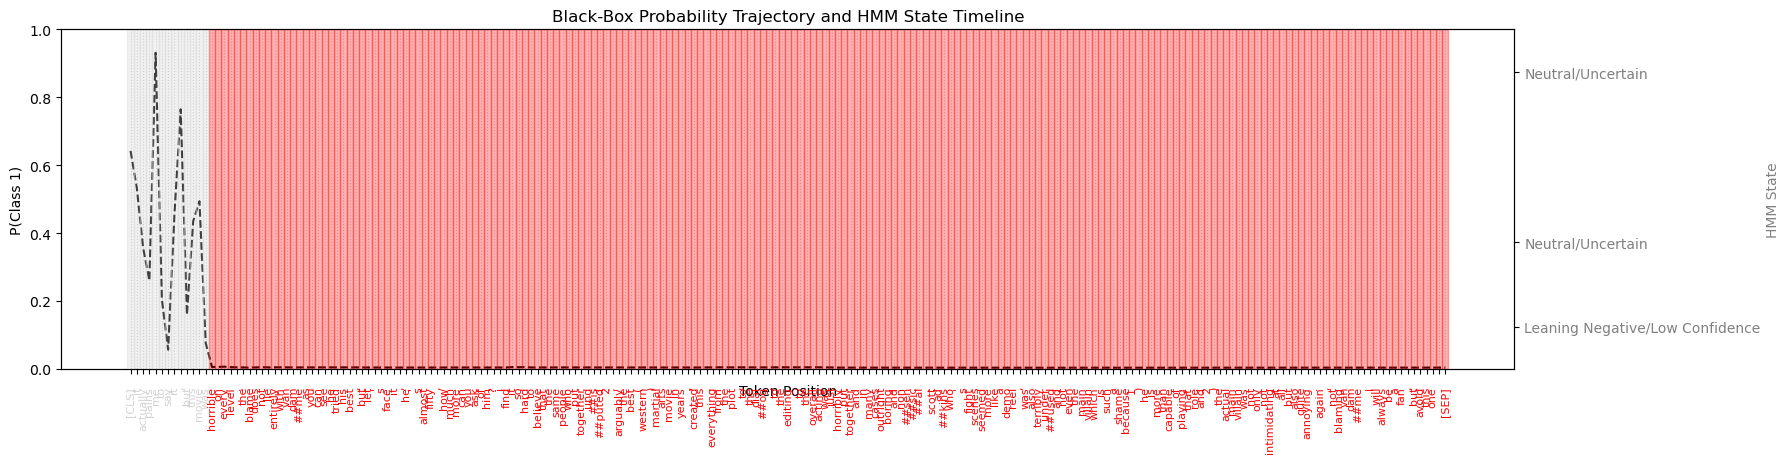


Visualizing Test Sample 9:
Text: Technically I'am a Van Damme Fan, or I was. this movie is so bad that I hated myself for wasting those 90 minutes. Do not let the name Isaac Florentine (Undisputed II) fool you, I had big hopes for th...

Sentence tokens with HMM colors:
[CLS] technically i ' am a van dam ##me fan , or i was . this movie is so bad that i hated myself for wasting those 90 minutes . do not let the name isaac fl ##ore ##ntine ( und ##is ##puted ii ) fool you , i had big hopes for this one , depending on what i saw in ( und ##is ##puted ii ) , man . . was i wrong ? ? ! all action fans wanted a big comeback for the classic action hero , but i guess we won ##t be able to see that soon , as our hero keep coming with those ( going - to - a - border - far - away - town - and - kill - the - bad - guys - than - comeback - home ) movies i mean for god ' s sake , we are in 2008 , and they insist on doing those disappointing movies on every level . why ? ? ! ! ! do your self a favor

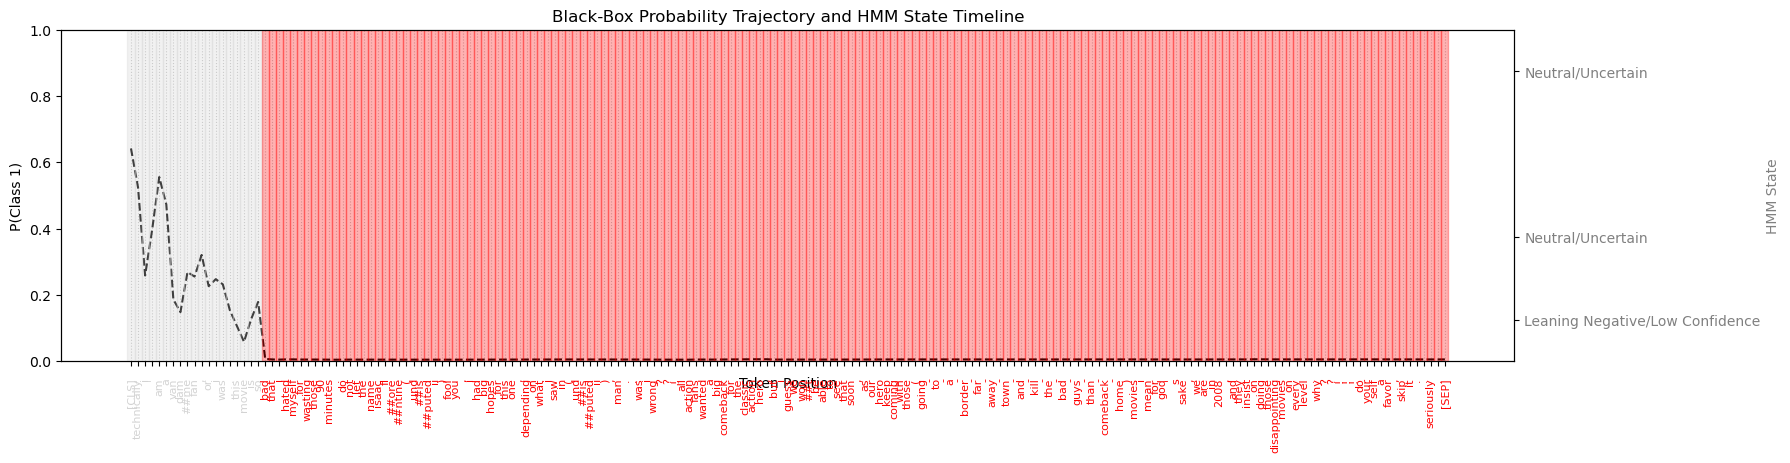


Visualizing Test Sample 10:
Text: Honestly awful film, bad editing, awful lighting, dire dialog and scrappy screenplay.<br /><br />The lighting at is so bad there's moments you can't even see what's going on, I even tried to playing w...

Sentence tokens with HMM colors:
[CLS] honestly awful film , bad editing , awful lighting , dire dial ##og and scrap ##py screenplay . < br / > < br / > the lighting at is so bad there ' s moments you can ' t even see what ' s going on , i even tried to playing with the contrast and brightness so i could see something but that didn ' t help . < br / > < br / > they must have found the script in a bin , the character development is just as awful and while you hardly expect much from a jean - claude van dam ##me film this one manages to hit an all time low . you can ' t even laugh at the che ##es ##y ' ness . < br / > < br / > the directing and editing are also terrible , the whole film follows an extremely tired routine and fails at every turn as it b

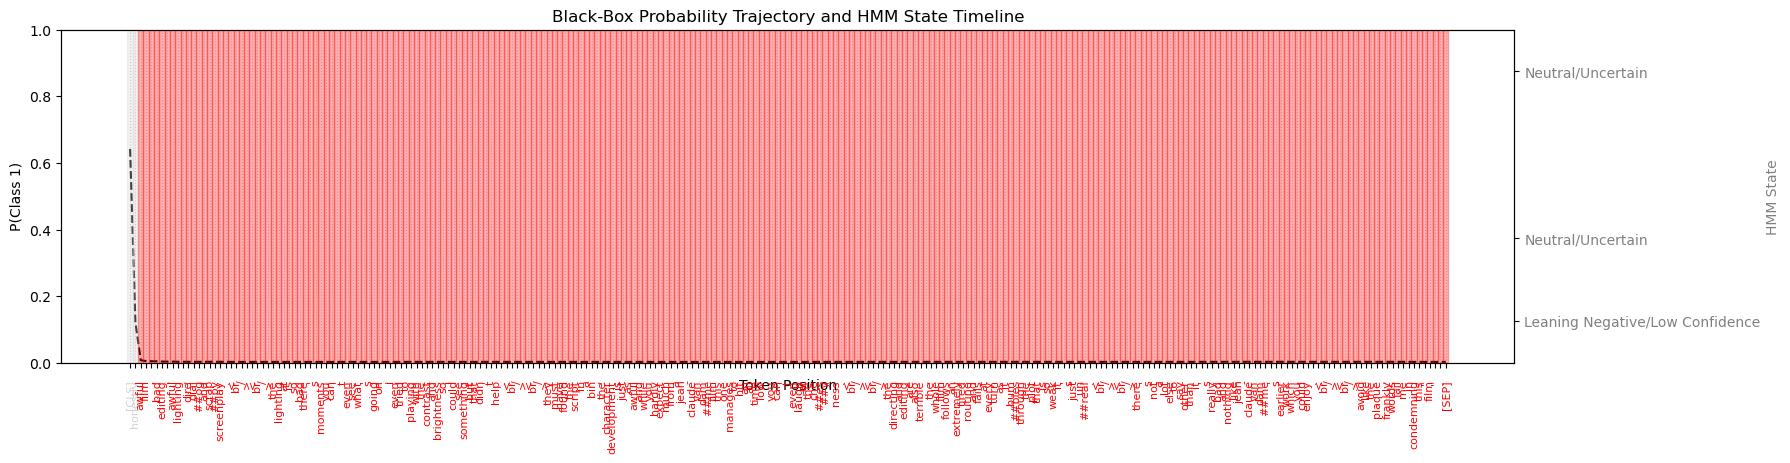


Visualizing Test Sample 11:
Text: This flick is a waste of time.I expect from an action movie to have more than 2 explosions and some shooting.Van Damme's acting is awful. He never was much of an actor, but here it is worse.He was def...

Sentence tokens with HMM colors:
[CLS] this flick is a waste of time . i expect from an action movie to have more than 2 explosions and some shooting . van dam ##me ' s acting is awful . he never was much of an actor , but here it is worse . he was definitely better in his earlier movies . his screenplay part for the whole movie was probably not more than one page of stupid nonsense one liner ##s . the whole dial ##og in the film is a disaster , same as the plot . the title " the shepherd " makes no sense . why didn ' t they just call it " border patrol " ? the fighting scenes could have been better , but either they weren ' t able to afford it , or the fighting choreographer was suffering from lack of ideas . this is a cheap low type of action cinem

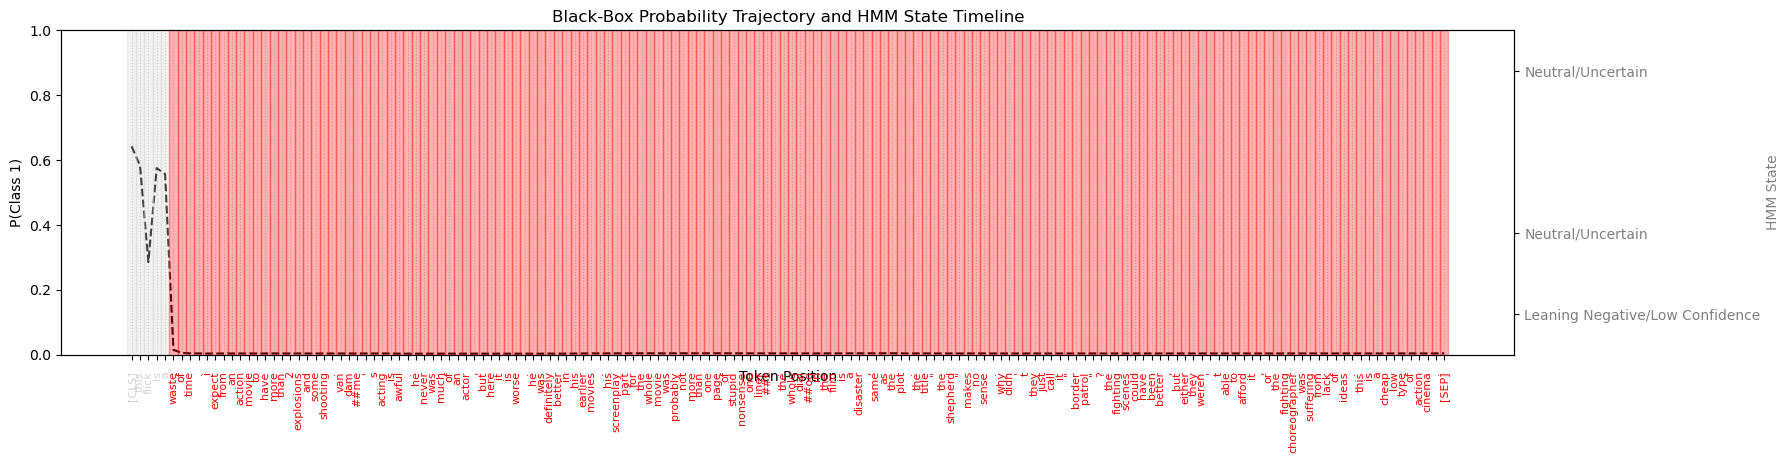


Visualizing Test Sample 12:
Text: Blind Date (Columbia Pictures, 1934), was a decent film, but I have a few issues with this film. First of all, I don't fault the actors in this film at all, but more or less, I have a problem with the...

Sentence tokens with HMM colors:
[CLS] blind date ( columbia pictures , 1934 ) , was a decent film , but i have a few issues with this film . first of all , i don ' t fault the actors in this film at all , but more or less , i have a problem with the script . also , i understand that this film was made in the 1930 ' s and people were looking to escape reality , but the script made ann so ##ther ##n ' s character look weak . she kept going back and forth between suit ##ors and i felt as though she should have stayed with paul kelly ' s character in the end . he truly did care about her and her family and would have done anything for her and he did by giving her up in the end to fi ##ckle neil hamilton who in my opinion was only out for a good time . p

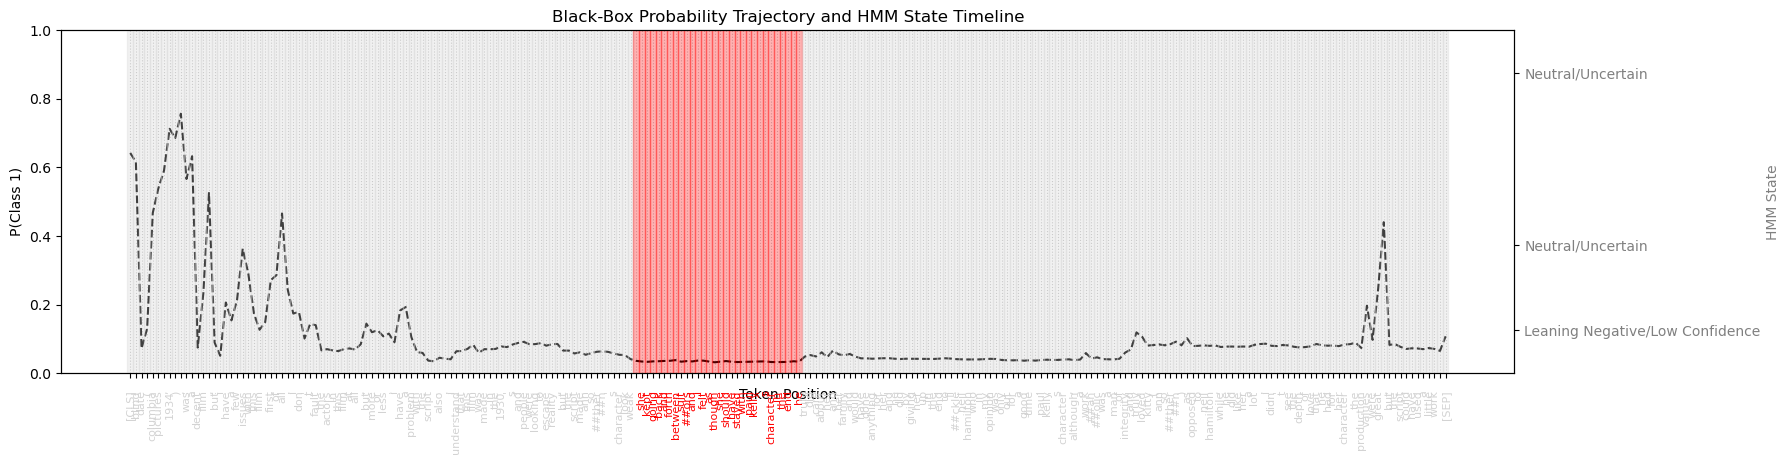


Visualizing Test Sample 13:
Text: I first watched this movie back in the mid/late 80's, when I was a kid. We couldn't even get all the way through it. The dialog, the acting, everything about it was just beyond lame.<br /><br />Here a...

Sentence tokens with HMM colors:
[CLS] i first watched this movie back in the mid / late 80 ' s , when i was a kid . we couldn ' t even get all the way through it . the dial ##og , the acting , everything about it was just beyond lame . < br / > < br / > here are a few examples . . . imagine these spoken real dramatically , way over - acted : " ore ##ego ##n ? you ' re going to ore ##ego ##n ? why would anyone want to go to ore ##ego ##n ? " < br / > < br / > " survival ##ists ? nobody ever told us about any survival ##ists ! " < br / > < br / > this movie was so bad , my sister and i rented it again for her 16th birthday party , just so our friends could sit around and laugh at how awful it was . i don ' t think we were able to finish it then either

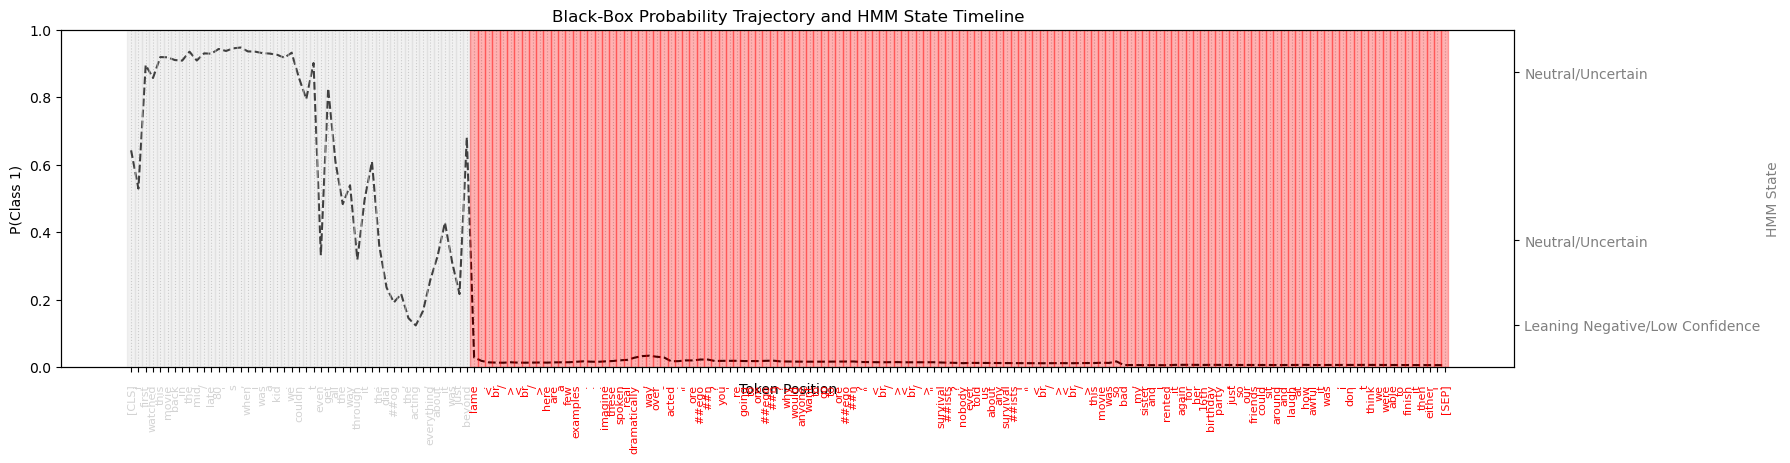


Visualizing Test Sample 14:
Text: I saw the Mogul Video VHS of this. That's another one of those old 1980s distributors whose catalog I wish I had!<br /><br />This movie was pretty poor. Though retitled "Don't Look in the Attic," the ...

Sentence tokens with HMM colors:
[CLS] i saw the mo ##gul video vhs of this . that ' s another one of those old 1980s distributors whose catalog i wish i had ! < br / > < br / > this movie was pretty poor . though re ##titled " don ' t look in the attic , " the main ad ##mon ##ition that is repeated in this is " don ' t go to the villa . " just getting on the grounds of the villa is a bad idea . a character doesn ' t go into the attic until an hour into the movie , and actually should have done it earlier because of what is learned there . < br / > < br / > the movie starts in turin , italy in the 1950s . two men are fighting , and a woman is telling them the villa is making them do it . one man kills the other , then regrets it , and the woman pulls

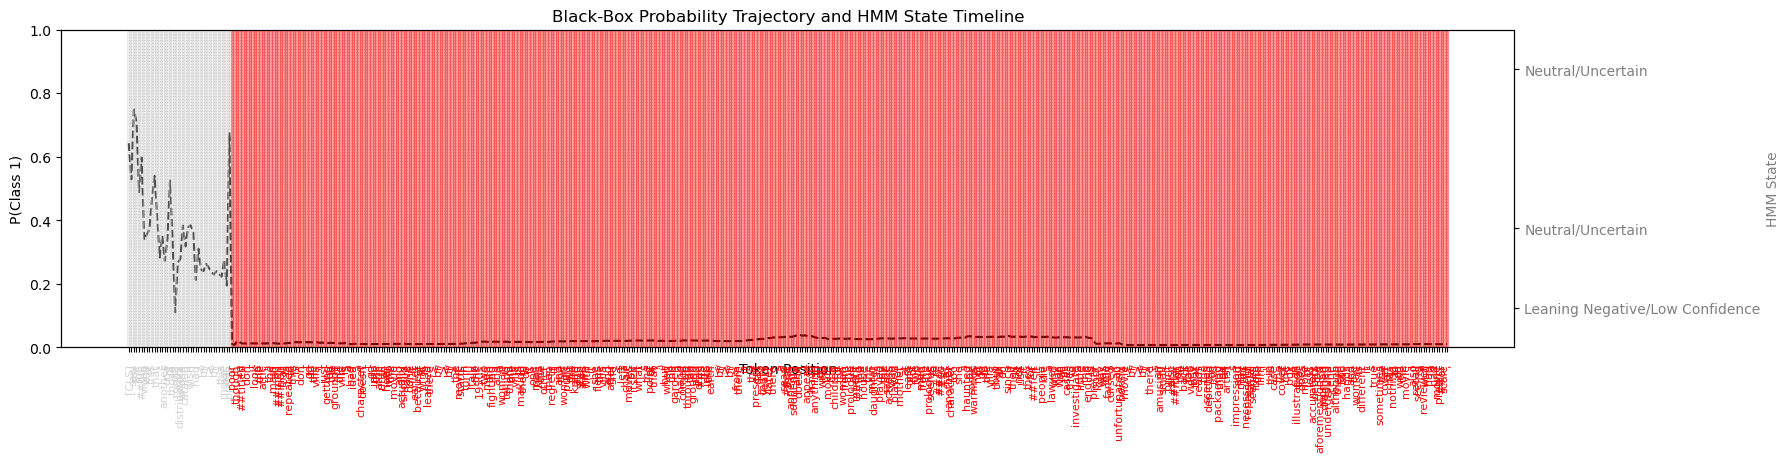


Visualizing Test Sample 15:
Text: A group of heirs to a mysterious old mansion find out that they have to live in it as part of a clause in the will or be disinherited, but they soon find out of its history of everybody whom had lived...

Sentence tokens with HMM colors:
[CLS] a group of heirs to a mysterious old mansion find out that they have to live in it as part of a clause in the will or be di ##sin ##her ##ited , but they soon find out of its history of everybody whom had lived there before them having either died in weird accidents or having had killed each other . < br / > < br / > you ' ve seen it all before , and this one is too low - budget and slow paced to be scary , and doesn ' t have any real surprises in the climax . no special effects or gore to speak of , in fact the only really amusing thing about the whole film is the quality of the english dub ##bing , which at times is as bad as a cheap martial arts movie . < br / > < br / > 3 out of 10 , pretty low in the peck #

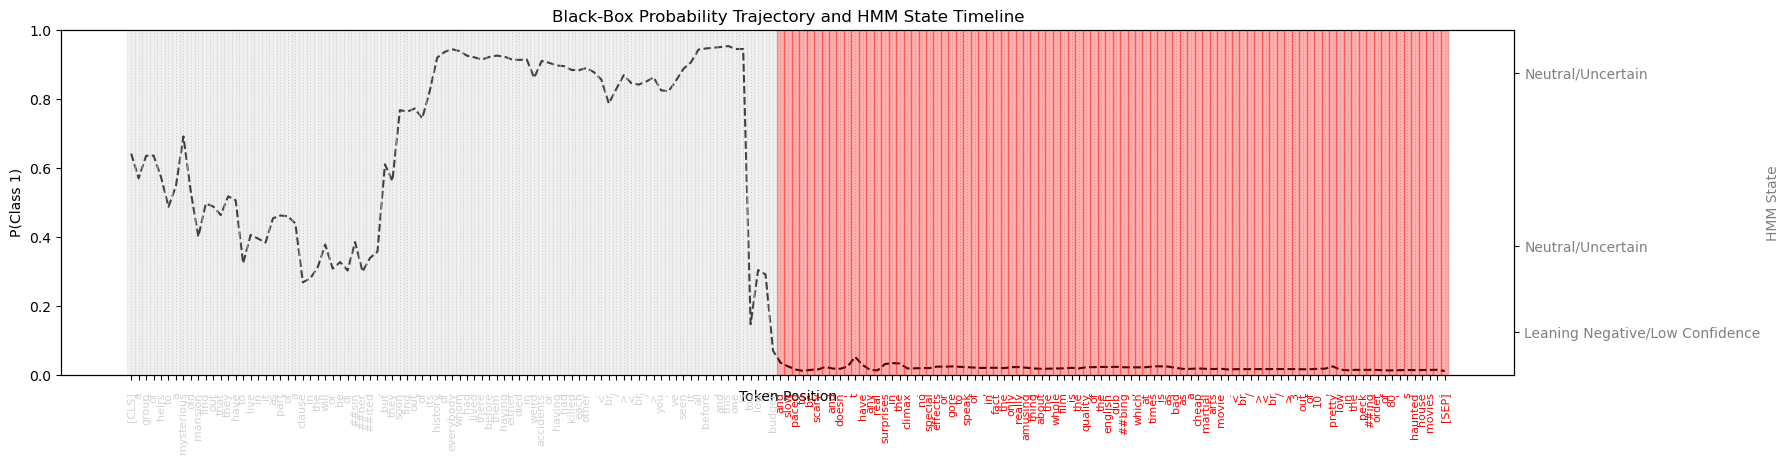


Visualizing Test Sample 16:
Text: Now, I LOVE Italian horror films. The cheesier they are, the better. However, this is not cheesy Italian. This is week-old spaghetti sauce with rotting meatballs. It is amateur hour on every level. Th...

Sentence tokens with HMM colors:
[CLS] now , i love italian horror films . the che ##es ##ier they are , the better . however , this is not che ##es ##y italian . this is week - old spaghetti sauce with rotting meat ##balls . it is amateur hour on every level . there is no suspense , no horror , with just a few drops of blood scattered around to remind you that you are in fact watching a horror film . the " special effects " consist of the lights changing to red whenever the ghost ( or whatever it was supposed to be ) is around , and a string pulling bed sheets up and down . o ##oo ##h , can you feel the chill ##s ? the dvd quality is that of a vhs transfer ( which actually helps the film more than hurts it ) . the dub ##bing is below even the lowest

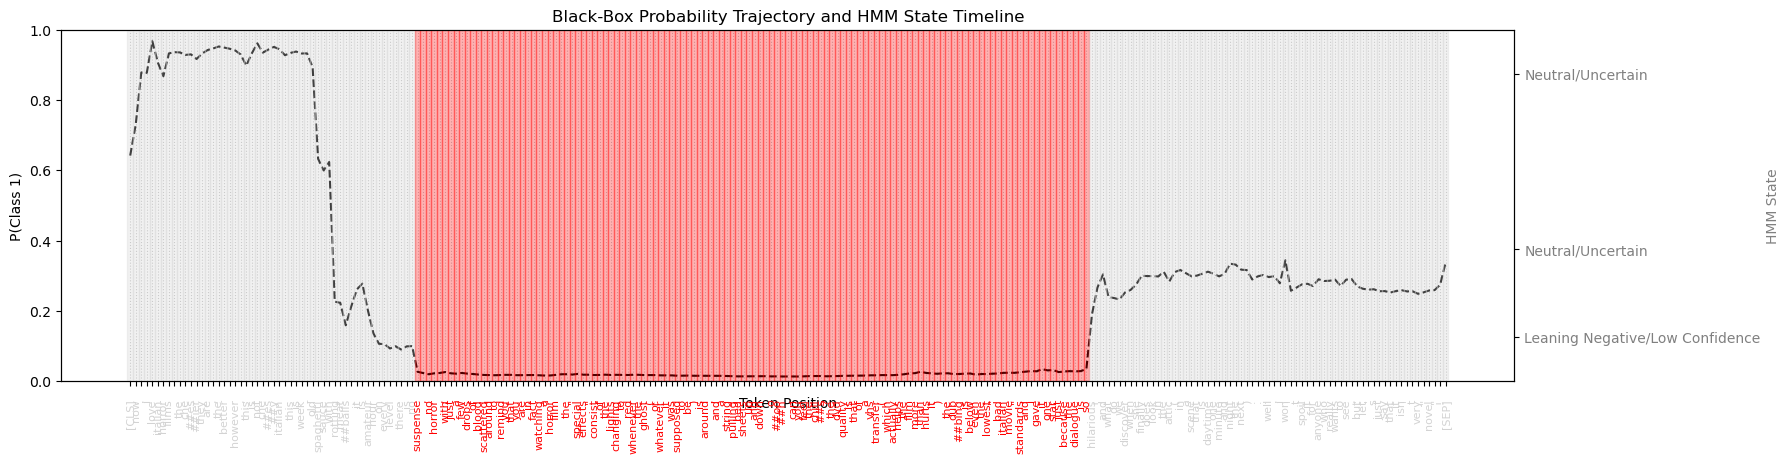


Visualizing Test Sample 17:
Text: This cheap, grainy-filmed Italian flick is about a couple of inheritors of a manor in the Italian countryside who head up to the house to stay, and then find themselves getting killed off by ghosts of...

Sentence tokens with HMM colors:
[CLS] this cheap , grain ##y - filmed italian flick is about a couple of inherit ##ors of a manor in the italian countryside who head up to the house to stay , and then find themselves getting killed off by ghosts of people killed in that house . < br / > < br / > i wasn ' t impressed by this . it wasn ' t really that scary , mostly just the way a cheap italian film should be . a girl , her two cousins , and one cousin ' s girlfriend , head to this huge house for some reason ( i couldn ' t figure out why ) and are staying there , cleaning up and checking out the place . characters come in and out of the film , and it ' s quite boring at points , and the majority of deaths are quite rushed . the girlfriend is hit by a 

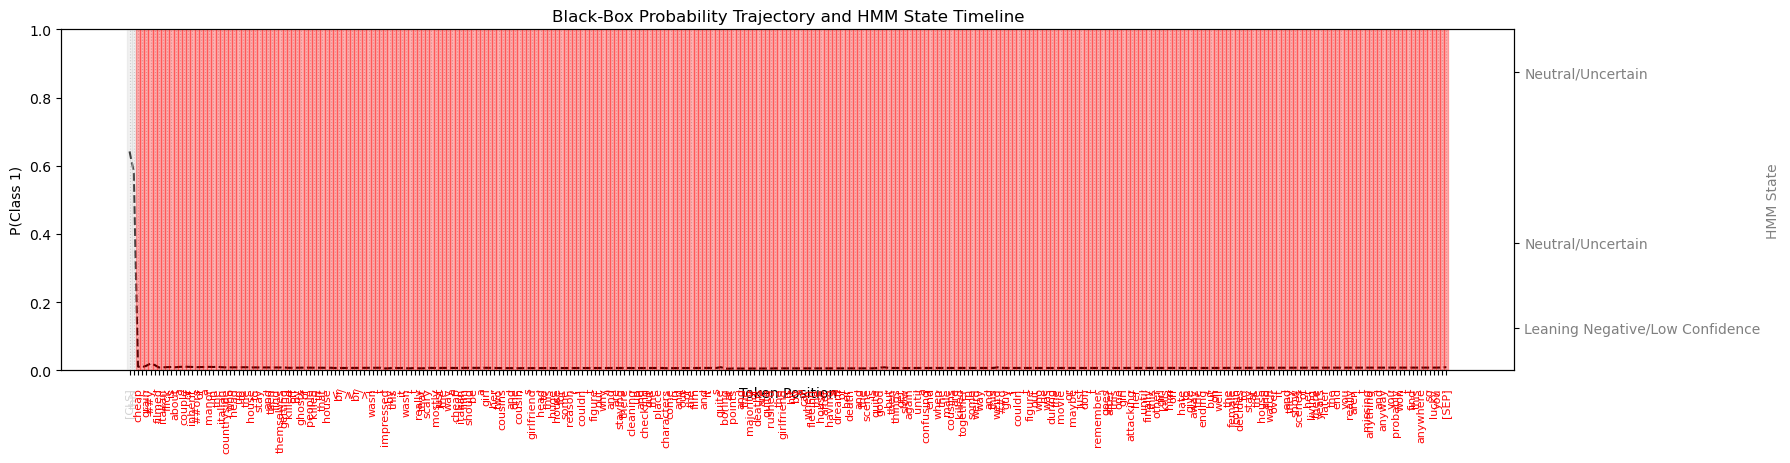


Visualizing Test Sample 18:
Text: I just finished watching this movie and am disappointed to say that I didn't enjoy it a bit. It is so slow Slow and uninteresting. This kid from Harry Potter plays a shy teenager with an rude mother, ...

Sentence tokens with HMM colors:
[CLS] i just finished watching this movie and am disappointed to say that i didn ' t enjoy it a bit . it is so slow slow and un ##int ##eres ##ting . this kid from harry potter plays a shy teenager with an rude mother , and then one day the rude mother tells the kid to find a job so that they could accommodate an old guy apparently having no place to live has started to live with his family and therefore the kid goes to work for a old lady . and this old lady who is living all alone teaches him about girls , driving car and life ! i couldn ' t get how an 18 year old guy enjoy spending time with an awful lady in her 80s . sorry if my comments on this movie has bothered people who might have enjoyed it , i could be wron

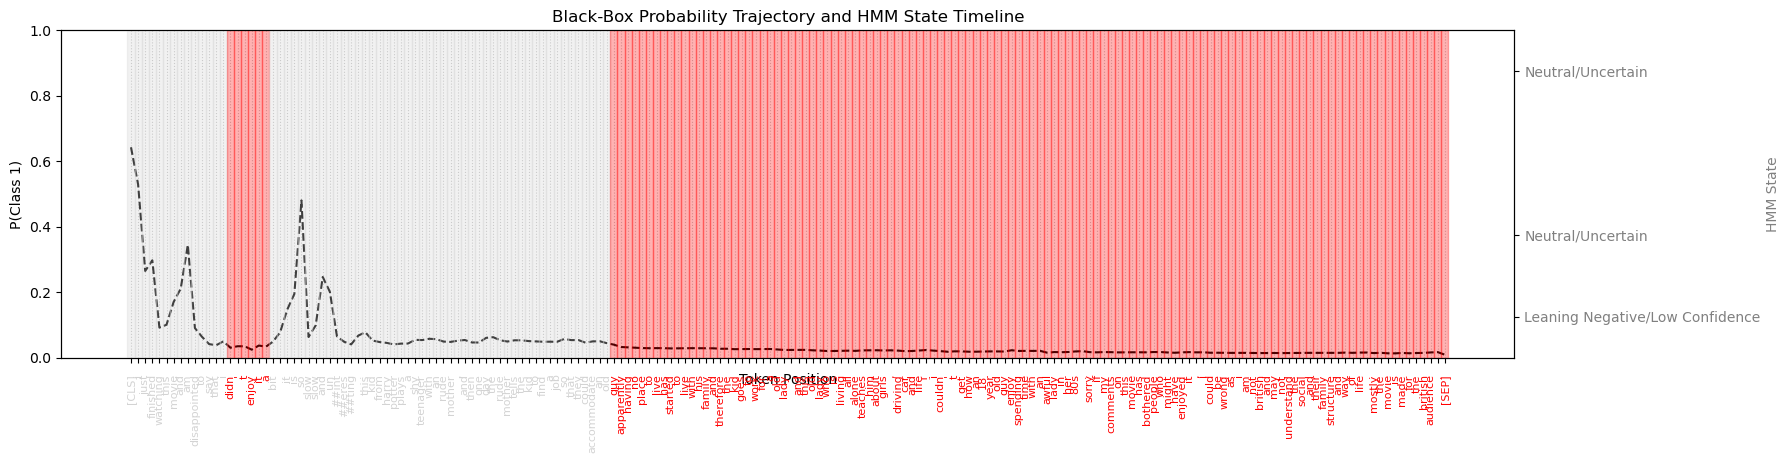


Visualizing Test Sample 19:
Text: Ben, (Rupert Grint), is a deeply unhappy adolescent, the son of his unhappily married parents. His father, (Nicholas Farrell), is a vicar and his mother, (Laura Linney), is ... well, let's just say sh...

Sentence tokens with HMM colors:
[CLS] ben , ( rupert grin ##t ) , is a deeply unhappy adolescent , the son of his un ##ha ##pp ##ily married parents . his father , ( nicholas farrell ) , is a vicar and his mother , ( laura lin ##ney ) , is . . . well , let ' s just say she ' s a somewhat h ##yp ##oc ##rit ##ical soldier in jesus ' army . it ' s only when he takes a summer job as an assistant to a foul - mouthed , eccentric , once - famous and now - forgotten actress evie walton , ( julie walters ) , that he finally finds himself in true ' harold and maud ##e ' fashion . of course , evie is deeply unhappy herself and it ' s only when these two sad sacks find each other that they can put their mutual misery aside and hit the road to happiness . < br /

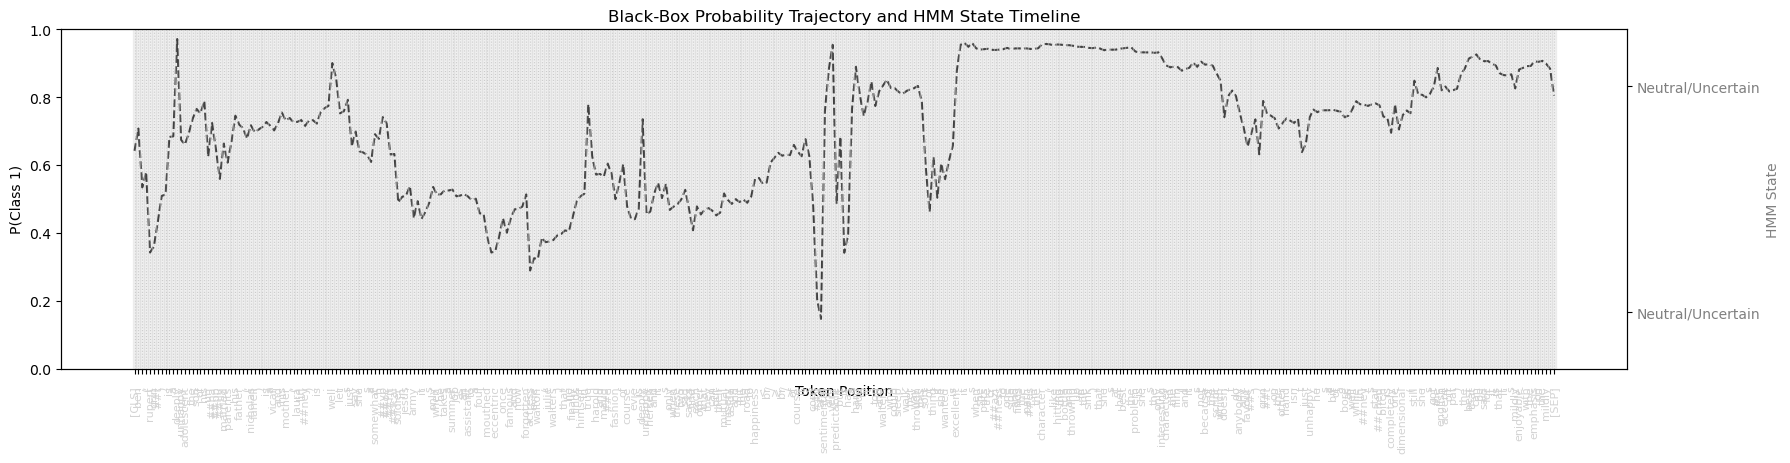


Visualizing Test Sample 20:
Text: Every movie I have PPV'd because Leonard Maltin praised it to the skies has blown chunks! Every single one! When will I ever learn?<br /><br />Evie is a raving Old Bag who thinks nothing of saying she...

Sentence tokens with HMM colors:
[CLS] every movie i have pp ##v ' d because leonard mal ##tin praised it to the skies has blown chunks ! every single one ! when will i ever learn ? < br / > < br / > evie is a ravi ##ng old bag who thinks nothing of saying she ' s dying of breast cancer to get her way ! laura is an ins ##uf ##fera ##ble med ##usa filled with the holy spirit ( and her hub ##by ' s protege ) ! caught between these harp ##ies is med ##usa ' s dumb - as - a - rock boy who has been pressed into weed - pulling ser ##vi ##tu ##de by the old bag ! < br / > < br / > as i said , when will i ever learn ? < br / > < br / > i was temporarily lifted out of my mala ##ise when the old bag stuck her head in a sink , but , unfortunately , she did not 

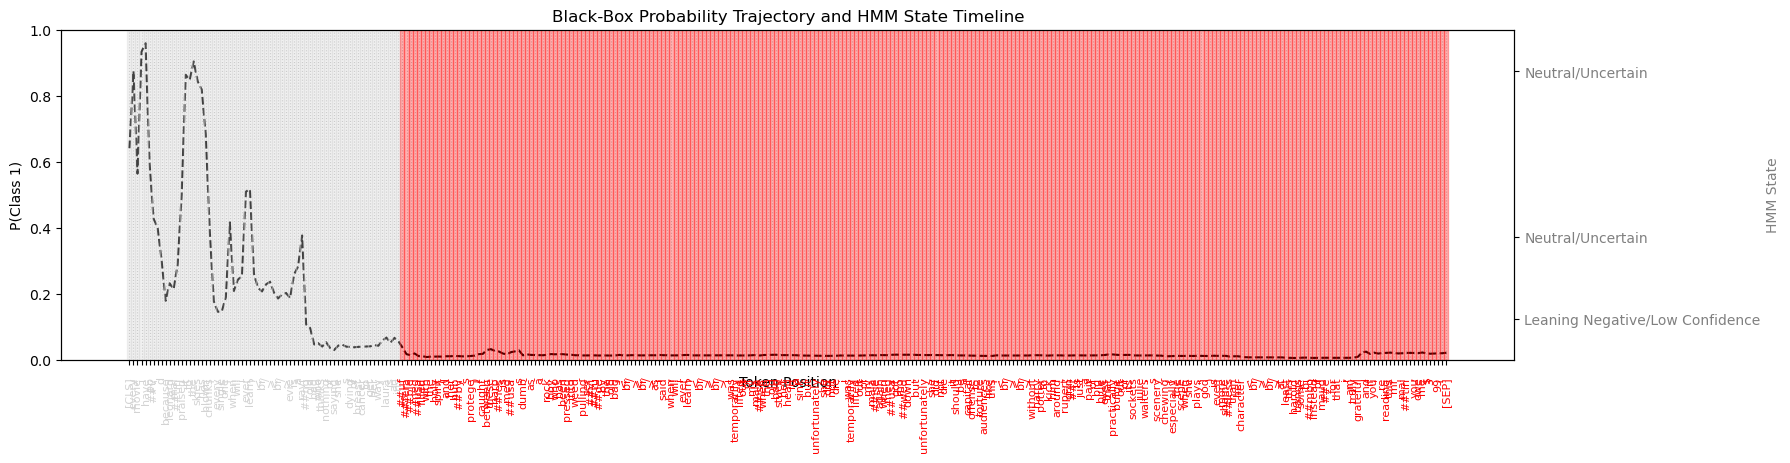

In [5]:
if hmm_surrogate_model and hmm_surrogate_model.is_trained and state_analysis_results:
    print("\n--- Visualizing HMM on Test Reviews ---")
    # Load black-box model for generating test trajectories
    bb_model_vis = BlackBoxSentimentClassifier(model_name=MODEL_NAME, device=DEVICE)
    tokenizer_vis = bb_model_vis.tokenizer

    # Load some test data
    imdb_test_raw = load_imdb_data(split='test', num_samples=NUM_TEST_SAMPLES, shuffle=False)
    processed_test_data = preprocess_data_for_inference_logging(imdb_test_raw, tokenizer_vis)

    # Get trajectories for test data
    test_trajectories_vis = log_inference_trajectories(processed_test_data, bb_model_vis, max_len=MAX_TOKENS)
    
    # Get the actual tokens for each processed test sample (up to MAX_TOKENS)
    test_tokens_vis = []
    for item in processed_test_data:
        # Ensure [CLS] is handled consistently if present
        cls_token_id = tokenizer_vis.cls_token_id
        actual_tokens = item['tokens']
        if cls_token_id is not None and item['input_ids'][0] == cls_token_id:
             # If CLS is already first, use tokens directly
             pass # actual_tokens = item['tokens']
        elif cls_token_id is not None:
             # Prepend [CLS] token string if model adds ID but it's not in original 'tokens'
             actual_tokens = [tokenizer_vis.cls_token] + item['tokens']
        
        test_tokens_vis.append(actual_tokens[:MAX_TOKENS])


    for i, (prob_traj, tokens) in enumerate(zip(test_trajectories_vis, test_tokens_vis)):
        if prob_traj.shape[0] == 0: continue # Skip empty trajectories

        decoded_states_vis = hmm_surrogate_model.decode_sequence(prob_traj)
        
        # Ensure token list length matches trajectory length for plotting
        # The trajectory length is min(len(original_tokens_with_cls), MAX_TOKENS)
        # The `tokens` list should be sliced to match this length.
        plot_tokens = tokens[:len(decoded_states_vis)]

        print(f"\nVisualizing Test Sample {i+1}:")
        print(f"Text: {processed_test_data[i]['text'][:200]}...")
        
        plt.figure(figsize=(18, 6))
        plot_state_timeline(
            plot_tokens,
            prob_traj,
            decoded_states_vis,
            state_names=state_analysis_results.get('state_names'),
            target_class_idx=TARGET_SENTIMENT,
            ax=plt.gca() # Pass current axes
        )
        plt.show()
else:
    print("Skipping visualization as HMM model is not available or not trained, or state analysis is missing.")